In [1]:
import torch
import torch.nn as nn
import torchdyn
from torchdyn.core import NeuralODE
import seaborn as sns
import matplotlib.pyplot as plt

from DynGenModels.datamodules.fermi.datasets import FermiDataset
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader
from DynGenModels.models.resnet import ResNet
from DynGenModels.models.resnet_config import ResNetConfig as Config
from DynGenModels.trainer.trainer import FlowMatchTrainer
from DynGenModels.dynamics.flowmatch import SimplifiedCondFlowMatching

In [8]:
config = Config(dataset = 'fermi_data_galactic_coord.npy',
                features    = ['theta', 'phi', 'energy'],
                preprocess  = ['normalize',  'standardize'],
                cuts = {
                        'theta': [-10., 10.], 
                        'phi': [4., 10.], 
                        'energy': [1000, 2000]
                        },
                data_split_fracs = [0.75, 0.25, 0.0],
                epochs = 30,
                early_stopping=10,
                batch_size = 10000,
                warmup_epochs = 10,
                lr = 1e-4,
                dim_hidden = 64, 
                num_layers = 2,
                device = 'cpu'
                )

root_dir =  '/home/df630/' if 'cuda' in config.device else '/Users/dario/Dropbox/PROJECTS/ML/'
root_dir += 'DynGenModels'
config.set_workdir(root_dir + '/results', save_config=True)


#===============================================================================================================================
INFO: created directory: /Users/dario/Dropbox/PROJECTS/ML/DynGenModels/results/ResNet.fermi_galactic_center_2023.09.23_15h07__1
#===============================================================================================================================
+------------------+-------------------------------+
| Key              | Value                         |
+------------------+-------------------------------+
| dataset          | fermi_data_galactic_coord.npy |
| data_name        | fermi_galactic_center         |
| features         | ['theta', 'phi', 'energy']    |
| preprocess       | ['normalize', 'standardize']  |
| cuts             | theta: [-10.0, 10.0]          |
|                  | phi: [4.0, 10.0]              |
|                  | energy: [1000, 2000]          |
| device           | cpu                           |
| data_split_fracs | [0.75, 0.2

In [9]:
resnet = ResNet(model_config=config)
datasets = FermiDataset(dir_path = root_dir + '/data/fermi', 
                        dataset = config.dataset,
                        cuts = config.cuts,
                        preprocess = config.preprocess,
                        ) 
dataloader = FermiDataLoader(datasets=datasets, data_split_fracs=config.data_split_fracs, batch_size=config.batch_size)


INFO: loading and preprocessing data...
torch.Size([162173, 3])
	- dataset: /Users/dario/Dropbox/PROJECTS/ML/DynGenModels/data/fermi 
 	- shape: torch.Size([162173, 3])
INFO: building dataloaders...
INFO: train/val/test split ratios: 0.75/0.25/0.0
INFO: train size: 121629, validation size: 40543, testing sizes: 1


In [10]:
dynamics = SimplifiedCondFlowMatching(model=resnet)

CFM = FlowMatchTrainer(dynamics=dynamics, 
                       dataloader=dataloader,
                       workdir=config.workdir,
                       lr=config.lr,
                       epochs=config.epochs,
                       early_stopping=config.early_stopping,
                       warmup_epochs=config.warmup_epochs)

CFM.train()

INFO: number of training parameters: 9971


epochs:   0%|          | 0/30 [00:00<?, ?it/s]

	 Test loss: 0.0014269687684672634  (min loss: 0.0014269687684672634)
	 Test loss: 0.000677549635843841  (min loss: 0.000677549635843841)
	 Training loss: 0.0003145514910692864
	 Test loss: 0.0002697445739813086  (min loss: 0.0002697445739813086)
	 Test loss: 0.00010974243920218053  (min loss: 0.00010974243920218053)
	 Training loss: 6.060328683640741e-05
	 Test loss: 6.014098954789396e-05  (min loss: 6.014098954789396e-05)
	 Test loss: 4.8374365511207064e-05  (min loss: 4.8374365511207064e-05)
	 Training loss: 3.999960467698747e-05


In [34]:


class torchdyn_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format.
    """
    def __init__(self, vector_field):
        super().__init__()
        self.vector_field = vector_field
    def forward(self, t, x):
        t = t.repeat(x.shape[:-1]+(1,), 1)
        return self.vector_field(t=t, x=x)

@torch.no_grad()
def ODEsolver(timesteps, 
			  source, 
			  net, 
			  solver='midpoint', 
			  sensitivity="adjoint", 
			  atol=1e-4, 
			  rtol=1e-4):

	net_wrapped = torchdyn_wrapper(vector_field=net)

	node = NeuralODE(vector_field=net_wrapped, 
					 solver=solver, 
					 sensitivity=sensitivity, 
					 seminorm=True if solver=='dopri5' else False,
					 atol=atol if solver=='dopri5' else None, 
					 rtol=rtol if solver=='dopri5' else None
					 )

	trajectories = node.trajectory(x=source, t_span=timesteps)
	return trajectories[-1] 



source = torch.rand((10000,3))
time = torch.linspace(0, 1, 300)
sample = ODEsolver(timesteps=time, source=source,  net=CFM.dynamics.model)



/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


In [42]:

mean, std, min, max = datasets.summary_statistics['dataset']
sample_ = sample_ * std + mean
sample_ = sample_ * (max - min) + min 

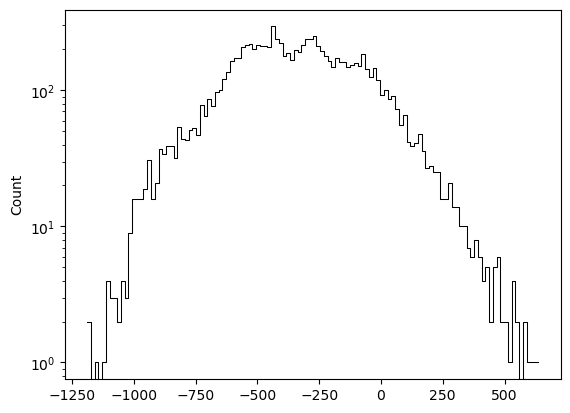

In [43]:
# plot sample only first col histogram

sns.histplot(x=sample_[:,0], color='k', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()


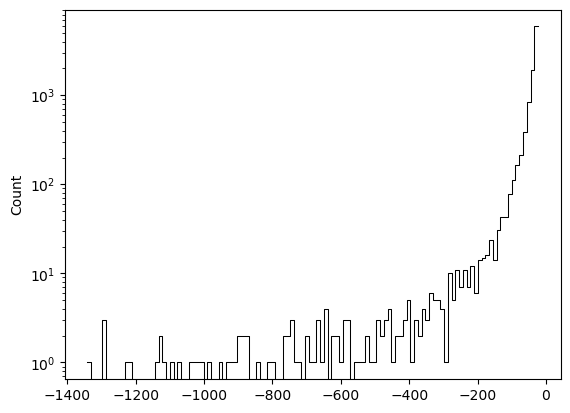

In [45]:
sns.histplot(x=sample_[:,1], color='k', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()

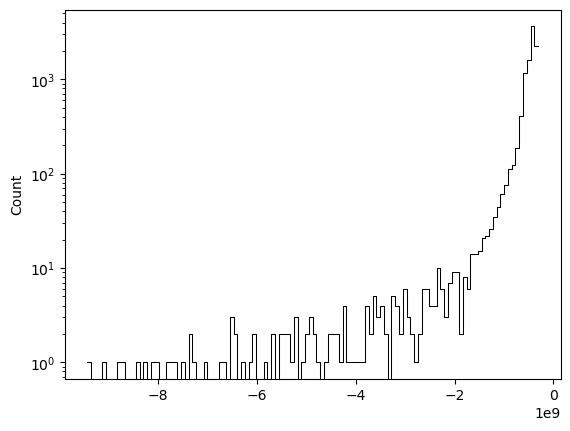

In [46]:
sns.histplot(x=sample_[:,2], color='k', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()

In [30]:
import torch
from torchdyn.core import NeuralODE
from DynGenModels.datamodules.fermi.process import PostProcessData
from DynGenModels.trainer.trainer import FlowMatchTrainer


class FlowMatchPipeline:
    
    def __init__(self, 
                 source_data: torch.Tensor=None,
                 pretrained_model: FlowMatchTrainer=None, 
                 solver: str='euler',
                 sampling_steps: int=100):
        
        super().__init__()

        self.source = source_data
        self.net = pretrained_model.dynamics.model
        self.stats = pretrained_model.dataloader.datasets.summary_statistics['dataset']
        self.postprocess = ['inverse_' + method for method in pretrained_model.dataloader.datasets.preprocess_methods[::-1]]
        self.time = torch.linspace(0, 1, sampling_steps)
        self.solver = solver
        self.trajectories = self.ODEsolver()

    @torch.no_grad()
    def ODEsolver(self, sensitivity="adjoint", atol=1e-4, rtol=1e-4):
        node = NeuralODE(vector_field=TorchdynWrapper(self.net), 
                        solver=self.solver, 
                        sensitivity=sensitivity, 
                        seminorm=True if self.solver=='dopri5' else False,
                        atol=atol if self.solver=='dopri5' else None, 
                        rtol=rtol if self.solver=='dopri5' else None
                        )
        trajectories = node.trajectory(x=self.source, t_span=self.time)
        return self.post_process(trajectories)

    def post_process(self, trajectories):
        sample = PostprocessData(data=trajectories, 
                                stats=self.stats,
                                methods=self.postprocess
                                )
        sample.postprocess()
        return sample.galactic_features



class TorchdynWrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format.
    """
    def __init__(self, net):
        super().__init__()
        self.nn = net
    def forward(self, t, x):
        t = t.repeat(x.shape[:-1]+(1,), 1)
        return self.nn(t=t, x=x)


In [66]:
pipeline = FlowMatchPipeline(pretrained_model=CFM, source_data=torch.rand((10000,3)), solver='dopri5', sampling_steps=400)


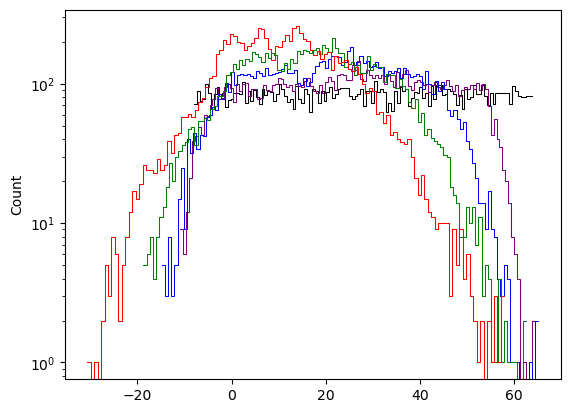

In [67]:
sns.histplot(x=pipeline.trajectories[0][:,0], color='k', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
sns.histplot(x=pipeline.trajectories[100][:,0], color='purple', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
sns.histplot(x=pipeline.trajectories[200][:,0], color='b', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
sns.histplot(x=pipeline.trajectories[300][:,0], color='g', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
sns.histplot(x=pipeline.trajectories[-1][:,0], color='r', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()


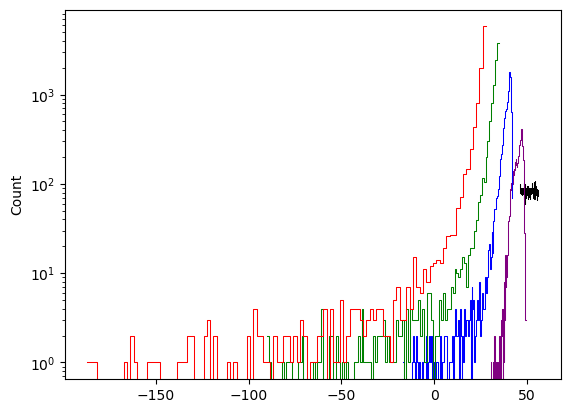

In [68]:
sns.histplot(x=pipeline.trajectories[0][:,1], color='k', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
sns.histplot(x=pipeline.trajectories[100][:,1], color='purple', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
sns.histplot(x=pipeline.trajectories[200][:,1], color='b', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
sns.histplot(x=pipeline.trajectories[300][:,1], color='g', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
sns.histplot(x=pipeline.trajectories[-1][:,1], color='r', bins=120,log_scale=(False, True), element="step", lw=0.75, fill=False, alpha=1) 
plt.show()
